<a href="https://colab.research.google.com/github/surafel58/Cervical-Cancer-Detection-Project/blob/main/Build_Cancer_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
import tensorflow_hub as hub

from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
#get data dir
data_dir = "/content/drive/MyDrive/Cervical Cancer dataset (Mendeley LBC)"

import pathlib
data_dir = pathlib.Path(data_dir)
# list(data_dir.glob('High squamous intra-epithelial lesion/*'))
image_count = len(list(data_dir.glob('*/*.jpg')))

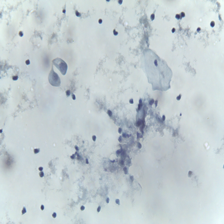

In [ ]:
#explore
hil = list(data_dir.glob('High squamous intra-epithelial lesion/*'))
PIL.Image.open(hil[-1]).resize((224, 224))

In [ ]:
#put the list of files and labels in dictionary
cancer_labels = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 
                 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']
cancer_images_dict = {
    'High squamous intra-epithelial lesion' : list(data_dir.glob('High squamous intra-epithelial lesion/*')),
    'Low squamous intra-epithelial lesion' : list(data_dir.glob('Low squamous intra-epithelial lesion/*')),
    'Negative for Intraepithelial malignancy' : list(data_dir.glob('Negative for Intraepithelial malignancy/*')),
    'Squamous cell carcinoma' : list(data_dir.glob('Squamous cell carcinoma/*'))
}

cancer_labels_dict = {
    'High squamous intra-epithelial lesion' : 0,
    'Low squamous intra-epithelial lesion' : 1,
    'Negative for Intraepithelial malignancy' : 2,
    'Squamous cell carcinoma' : 3
}

len(cancer_images_dict['Negative for Intraepithelial malignancy'])

612

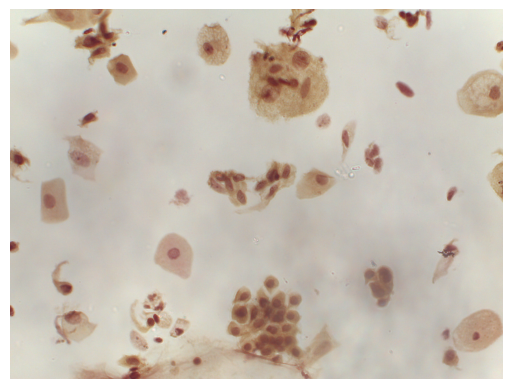

In [ ]:
#using cv2
img = cv2.imread(str(cancer_images_dict['High squamous intra-epithelial lesion'][0]))
plt.axis('off')
plt.imshow(img)

In [ ]:
#put the resized image in X
X, y = [], []
INPUT_SHAPE = (224, 224) #(256,256) 

with tf.device('/GPU: 0'):

  for cancer_type, cancer_images in cancer_images_dict.items():
    for image in cancer_images:
      img = PIL.Image.open(image)
      img = np.array(img)
      resized_img = cv2.resize(img, INPUT_SHAPE)
      X.append(resized_img)
      y.append(cancer_labels_dict[cancer_type])

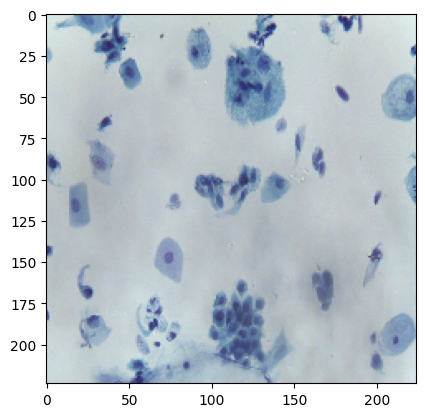

In [ ]:
X = np.array(X)
y = np.array(y)
plt.imshow(X[0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size=0.2)
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
#Original
data_agumentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    # tf.keras.layers.RandomCrop(128, 224),
    tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    tf.keras.layers.RandomContrast(0.2)
])


# input_shape = (256, 256, 3) #(224, 224, 3) 

# data_agumentation = keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape = input_shape),
#     layers.experimental.preprocessing.RandomRotation((-20, 20)),
#     # layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomZoom(0.2),
#     # tf.keras.layers.RandomCrop(128, 256),
#     layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
#     # tf.keras.layers.RandomBrightness([-0.3,0.3]),
#     layers.RandomContrast(0.2)
# ])

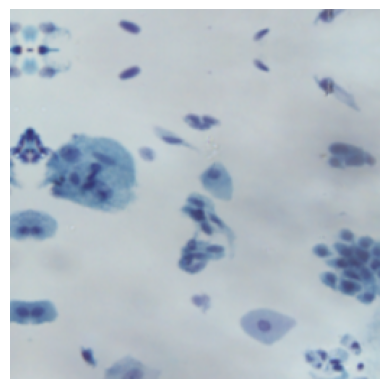

In [ ]:
plt.axis('off')
plt.imshow(data_agumentation(X)[0].numpy().astype("uint8"))

In [ ]:
num_classes = 4

#using Transfer learning
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

model = tf.keras.Sequential([
  data_agumentation,
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])



#Original 97%
# model = Sequential([
#   data_agumentation,
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(128, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(300, activation='relu'),
#   layers.Dense(num_classes, activation='softmax')
# ])


# 92%, 90 %

# model = Sequential([
#   data_agumentation,
#   layers.Conv2D(32, 3, padding='same', strides=(2,2), activation='relu'),
#   layers.BatchNormalization(),
#   layers.ReLU(),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', strides = (2,2),  activation='relu'),
#   # layers.Conv2D(64, 3, padding='same', strides = (2,2),  activation='relu'),
#   layers.BatchNormalization(),
#   layers.ReLU(),
#   layers.MaxPooling2D(),
#   layers.Conv2D(8, 3, padding='same', strides = (2,2),  activation='relu'),
#   # layers.Conv2D(128, 3, padding='same',  strides = (2,2), activation='relu'),
#   layers.BatchNormalization(),
#   layers.ReLU(),
#   layers.MaxPooling2D(),
#   layers.Conv2D(16, 3, padding='same', strides = (2,2),  activation='relu'),
#   # layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.BatchNormalization(),
#   layers.ReLU(),
#   layers.Dropout(0.3),
#   layers.Flatten(),
#   layers.Dense(300, activation='relu'),
#   layers.Dense(num_classes, activation='softmax')
# ])

# model.compile (optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
#               # optimizer="adam",
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
              


model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])




# model.fit(X_train_scaled, y_train, epochs=30, validation_split=0.1)

model.fit(X_train_scaled, y_train, epochs=80, validation_split=0.1)

# model.fit(X_train_scaled, y_train, epochs=100, batch_size = 64, validation_split=0.1)


Epoch 1/80


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


22/22 [==============================] - 7s 85ms/step - loss: 1.0999 - accuracy: 0.5867 - val_loss: 0.8732 - val_accuracy: 0.7273
Epoch 2/80
22/22 [==============================] - 1s 52ms/step - loss: 0.5930 - accuracy: 0.7616 - val_loss: 0.4995 - val_accuracy: 0.8571
Epoch 3/80
22/22 [==============================] - 1s 54ms/step - loss: 0.4582 - accuracy: 0.8324 - val_loss: 0.4302 - val_accuracy: 0.8831
Epoch 4/80
22/22 [==============================] - 1s 52ms/step - loss: 0.4045 - accuracy: 0.8468 - val_loss: 0.4152 - val_accuracy: 0.8571
Epoch 5/80
22/22 [==============================] - 1s 52ms/step - loss: 0.3548 - accuracy: 0.8887 - val_loss: 0.3841 - val_accuracy: 0.8571
Epoch 6/80
22/22 [==============================] - 1s 54ms/step - loss: 0.3031 - accuracy: 0.8916 - val_loss: 0.3886 - val_accuracy: 0.8442
Epoch 7/80
22/22 [==============================] - 1s 52ms/step - loss: 0.2687 - accuracy: 0.9147 - val_loss: 0.3931 - val_accuracy: 0.8701
Epoch 8/80
22/22 [======

In [ ]:
model.evaluate(X_test_scaled, y_test)
# model.save("/content/drive/MyDrive/Cervical Cancer dataset (Mendeley LBC)/My model testing Folder /98_model.h5")

7/7 [==============================] - 0s 42ms/step - loss: 0.1196 - accuracy: 0.9585


In [ ]:
predicted = model.predict(X_test_scaled)
temp = []
for i in range(len(predicted)):
  temp.append(np.argmax(predicted[i]))

predicted = temp

7/7 [==============================] - 1s 46ms/step


Text(95.72222222222221, 0.5, 'Truth')

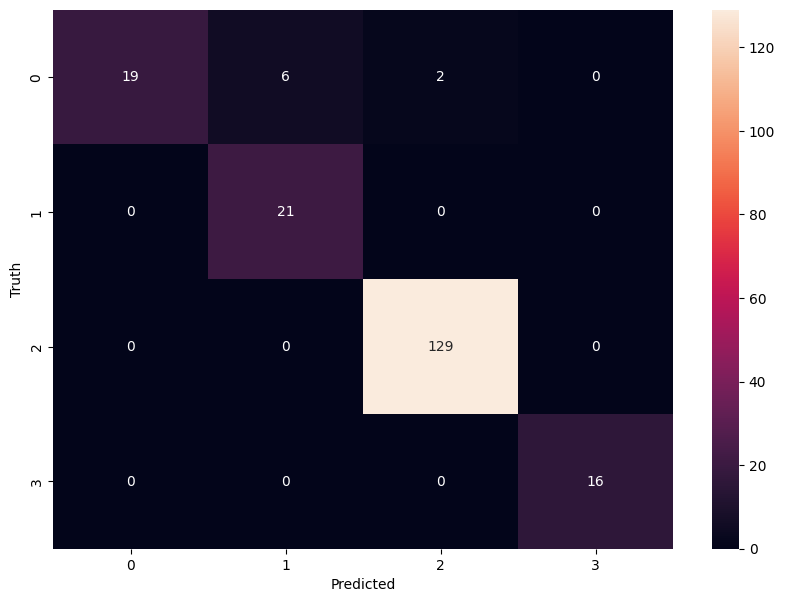

In [ ]:
import seaborn as sn
cm = tf.math.confusion_matrix(labels=y_test,predictions=predicted)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      0.70      0.83        27
           1       0.78      1.00      0.88        21
           2       0.98      1.00      0.99       129
           3       1.00      1.00      1.00        16

    accuracy                           0.96       193
   macro avg       0.94      0.93      0.92       193
weighted avg       0.97      0.96      0.96       193



In [ ]:
testing_dir = '/content/drive/MyDrive/Cervical Cancer dataset (Mendeley LBC)/My model testing Folder '
testing_images = ['/LSIL,_ThinPrep_Pap_(3704903464).jpg', '/High-grade_squamous_intraepithelial_lesion.jpg', '/Squamous_cell_carcinoma_in_the_cervix,_pap_stain.jpg', '/NILM.jpg', '/Low_grade_squamous_intraepithelial_lesion.jpg', '/HSIL01.jpg']
testing_img = testing_dir + testing_images[-1]
img = PIL.Image.open(testing_img)
img = np.array(img)
input_shape = (224,224)
img = cv2.resize(img, input_shape)
img = img / 255
# plt.imshow(img)
# img.shape
img = img.reshape((1, 224, 224, 3))

# result = model.predict(img)
result = model.predict(X_test_scaled)[0]

print(result)
print(result * 100)

result = np.argmax(result) 

cancer_labels[result]

7/7 [==============================] - 0s 45ms/step
[7.5234863e-07 7.7691759e-08 9.9999917e-01 2.1149274e-08]
[7.5234864e-05 7.7691757e-06 9.9999916e+01 2.1149274e-06]
[2 2 0 2 2 1 2 2 2 2 0 3 2 2 2 2 2 2 2 2 0 2 2 1 2 1 2 2 2 2 2 2 1 2 3 3 1
 2 2 2 2 2 1 2 2 2 2 2 2 1 0 0 2 2 1 3 2 2 2 2 2 2 0 2 2 2 1 2 2 2 0 3 1 0
 2 1 2 2 2 2 0 1 2 0 1 2 0 2 2 2 1 2 3 2 2 3 2 2 3 2 2 2 2 2 0 2 0 2 2 2 1
 2 2 2 2 2 1 0 1 0 0 2 2 2 2 2 3 0 2 2 2 2 2 2 2 0 2 2 2 3 2 2 2 2 1 3 2 0
 2 2 2 2 1 2 2 3 2 2 2 0 2 2 2 2 3 0 2 2 2 2 2 1 2 2 2 3 0 3 0 2 2 0 0 0 2
 3 2 1 2 2 2 0 2]


In [8]:
import pathlib
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

#Preprocess Input
def preProcessImage(image_path):

    img = PIL.Image.open(image_path)
    img = np.array(img)
    
    input_shape = (224,224)
    
    img = cv2.resize(img, input_shape)
    img = img / 255
    
    return img

#Display Output
def displayOutput(model_path, img):
    
    #load model 
    model = tf.keras.models.load_model(
       (model_path),
       custom_objects={'KerasLayer': hub.KerasLayer}
    )

    cancer_labels = ['High squamous intra-epithelial lesion', 'Low squamous intra-epithelial lesion', 
                 'Negative for Intraepithelial malignancy', 'Squamous cell carcinoma']

    #Predict
    img = img.reshape((1, 224, 224, 3))
    classification = model.predict(img)
   
    probability = classification * 100
    probability = np.max(probability)
    classification = np.argmax(classification)
    
    result_description = dict()
    
    #Define the Cancer Classification
    label = cancer_labels[classification]
    result_description["Cancer Classification"] = label 
    
    #Define the Cells Condition : cancerous, pre-cancerous, normal 
    if classification == 0 or classification == 3:
      result_description["Cells condition"] = "Cancerous"
    
    elif classification == 1:
      result_description["Cells condition"] = "Pre-cancerous"
    
    else:
      result_description["Cells condition"] = "Normal"

    #Define the Cellular Change
    result_description["Cellular Change"] = "Abnormal"

    if classification == 2:
      result_description["Cellular Change"] = "Normal"

    #Define Probability of classification
    result_description["probability of classification"] = "{:.2f}".format(probability) + " %"

    return result_description

#Display image
def displayImage(image_path):
  image_path = pathlib.Path(image_path)
  img = PIL.Image.open(image_path)
  return img


img = preProcessImage("/content/drive/MyDrive/Cervical Cancer dataset (Mendeley LBC)/Squamous cell carcinoma/scc_1 (11).jpg")
displayOutput("/content/drive/MyDrive/Cervical Cancer dataset (Mendeley LBC)/My model testing Folder /98_model.h5", img)

1/1 [==============================] - 0s 344ms/step


{'Cancer Classification': 'Squamous cell carcinoma',
 'Cells condition': 'Cancerous',
 'Cellular Change': 'Abnormal',
 'probability of classification': '98.70 %'}